# **Assignment 1**
**Natalia Del Rio**

**R11859713**


---



# **Imported Libraries**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import math
import time
from google.colab import files

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.tree import plot_tree

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer, LancasterStemmer

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True



---



# **Task 1 : Data Exploration and Understanding**



TASK 1: DATA EXPLORATION AND UNDERSTANDING
Training shape: (3728, 2)
Test shape: (869, 2)
Columns: ['essay', 'label']

Basic Statistics:
Number of samples: 3728
Number of classes: 2
Human (0): 1864 (50.0%)
AI (1): 1864 (50.0%)

Sample Human text:
International sports events require the most well-trained athletes for each country, in order to achieve this goal countries make an effort to build infrastructure designed to train top athletes. Although this policy can indeed make fewer sports facilities for ordinary people, investing in the best ...

Sample AI text:
International sports events demand that countries field their most highly trained athletes, which is why many nations invest in specialized facilities to help their top performers succeed. While this approach can sometimes mean fewer sports facilities are available for the general public, supporting...


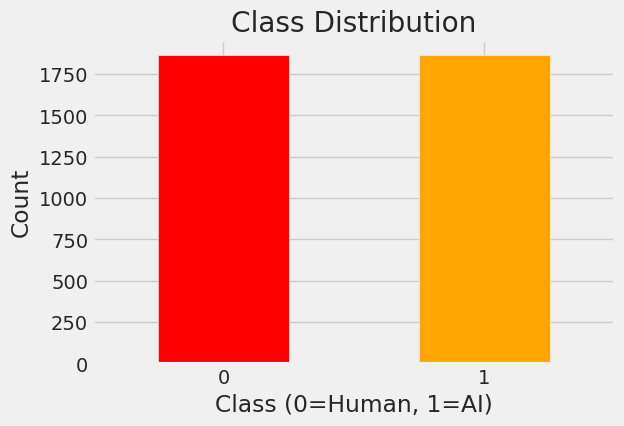

In [22]:
print("TASK 1: DATA EXPLORATION AND UNDERSTANDING")
print("="*50)

df_train = pd.read_excel('AI_vs_huam_train_dataset.xlsx')
df_test = pd.read_csv('Final_test_data.csv')

print(f"Training shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Columns: {df_train.columns.tolist()}")

print(f"\nBasic Statistics:")
print(f"Number of samples: {len(df_train)}")
print(f"Number of classes: {df_train['label'].nunique()}")

class_counts = df_train['label'].value_counts().sort_index()
print(f"Human (0): {class_counts[0]} ({class_counts[0]/len(df_train)*100:.1f}%)")
print(f"AI (1): {class_counts[1]} ({class_counts[1]/len(df_train)*100:.1f}%)")

print(f"\nSample Human text:")
print(df_train[df_train['label'] == 0]['essay'].iloc[0][:300] + "...")

print(f"\nSample AI text:")
print(df_train[df_train['label'] == 1]['essay'].iloc[0][:300] + "...")

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['red', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class (0=Human, 1=AI)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



---



# **Task 2 : Text Preprocessing**

In [23]:
print("\nTask 2: Text Preprocessing")
print("="*40)

stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
snowball = SnowballStemmer('english')
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

print("\n2.1 STOP WORDS REMOVAL")

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word not in stop_words])

df_train['clean'] = df_train['essay'].apply(clean_text)
df_train['no_stopwords'] = df_train['clean'].apply(remove_stopwords)
df_test['clean'] = df_test['essay'].apply(clean_text)
df_test['no_stopwords'] = df_test['clean'].apply(remove_stopwords)

print(f"Before: {df_train['clean'].iloc[0][:150]}...")
print(f"After: {df_train['no_stopwords'].iloc[0][:150]}...")

orig_vocab = len(set(' '.join(df_train['clean']).split()))
filtered_vocab = len(set(' '.join(df_train['no_stopwords']).split()))
print(f"\nVocabulary: {orig_vocab:,} → {filtered_vocab:,} words")

print("\n2.2 STEMMING TECHNIQUES")

df_train['porter'] = df_train['no_stopwords'].apply(lambda x: ' '.join([porter.stem(w) for w in x.split()]))
df_train['snowball'] = df_train['no_stopwords'].apply(lambda x: ' '.join([snowball.stem(w) for w in x.split()]))
df_train['lancaster'] = df_train['no_stopwords'].apply(lambda x: ' '.join([lancaster.stem(w) for w in x.split()]))

df_test['porter'] = df_test['no_stopwords'].apply(lambda x: ' '.join([porter.stem(w) for w in x.split()]))
df_test['snowball'] = df_test['no_stopwords'].apply(lambda x: ' '.join([snowball.stem(w) for w in x.split()]))
df_test['lancaster'] = df_test['no_stopwords'].apply(lambda x: ' '.join([lancaster.stem(w) for w in x.split()]))

print("\n2.3 LEMMATIZATION TECHNIQUES")

df_train['lemmatized'] = df_train['no_stopwords'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))
df_test['lemmatized'] = df_test['no_stopwords'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))

words = ['running', 'flies', 'dogs', 'better']
print(f"{'Word':<10} {'Porter':<10} {'Snowball':<10} {'Lancaster':<10} {'Lemma':<10}")
for word in words:
    print(f"{word:<10} {porter.stem(word):<10} {snowball.stem(word):<10} {lancaster.stem(word):<10} {lemmatizer.lemmatize(word):<10}")



Task 2: Text Preprocessing

2.1 STOP WORDS REMOVAL
Before: international sports events require the most well-trained athletes for each country, in order to achieve this goal countries make an effort to build i...
After: international sports events require well-trained athletes country, order achieve goal countries make effort build infrastructure designed train top at...

Vocabulary: 39,830 → 39,657 words

2.2 STEMMING TECHNIQUES

2.3 LEMMATIZATION TECHNIQUES
Word       Porter     Snowball   Lancaster  Lemma     
running    run        run        run        running   
flies      fli        fli        fli        fly       
dogs       dog        dog        dog        dog       
better     better     better     bet        better    




---



# **Task 3 : Feature Extraction**

In [24]:
print("\nTask 3: Feature Extraction")
print("="*30)

train_text = df_train['lemmatized']
test_text = df_test['lemmatized']

print("1. TF-IDF VECTORIZATION")

tfidf1 = TfidfVectorizer(ngram_range=(1,1), max_features=5000, min_df=2, max_df=0.8)
tfidf2 = TfidfVectorizer(ngram_range=(1,2), max_features=5000, min_df=2, max_df=0.8)
tfidf3 = TfidfVectorizer(ngram_range=(1,3), max_features=5000, min_df=2, max_df=0.8)

X_train_tfidf = tfidf3.fit_transform(train_text)
X_test_tfidf = tfidf3.transform(test_text)

print(f"Unigrams: {tfidf1.fit_transform(train_text).shape}")
print(f"Bigrams: {tfidf2.fit_transform(train_text).shape}")
print(f"Trigrams: {X_train_tfidf.shape}")

print("\n2. BAG OF WORDS")

bow1 = CountVectorizer(ngram_range=(1,1), max_features=5000, min_df=2, max_df=0.8)
bow2 = CountVectorizer(ngram_range=(1,2), max_features=5000, min_df=2, max_df=0.8)

X_train_bow = bow2.fit_transform(train_text)
X_test_bow = bow2.transform(test_text)

print(f"Unigrams: {bow1.fit_transform(train_text).shape}")
print(f"Bigrams: {X_train_bow.shape}")

y = df_train['label']
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y, test_size=0.2, random_state=42)


Task 3: Feature Extraction
1. TF-IDF VECTORIZATION
Unigrams: (3728, 5000)
Bigrams: (3728, 5000)
Trigrams: (3728, 5000)

2. BAG OF WORDS
Unigrams: (3728, 5000)
Bigrams: (3728, 5000)




---



# **Task 4 : Machine Learning Model Development**

In [25]:
print("\nTask 4: Machine Learning Model Development")
print("="*45)

print("\n4.1 Support Vector Machine")

svm_linear = SVC(kernel='linear', random_state=42, probability=True)
svm_rbf = SVC(kernel='rbf', random_state=42, probability=True)

svm_linear.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)

print(f"Linear: {svm_linear.score(X_val, y_val):.4f}")
print(f"RBF: {svm_rbf.score(X_val, y_val):.4f}")

if svm_linear.score(X_val, y_val) > svm_rbf.score(X_val, y_val):
    best_svm = svm_linear
    print("Best: Linear kernel")
else:
    best_svm = svm_rbf
    print("Best: RBF kernel")

print("\n4.2 Decision Tree")

dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)

dt_gini.fit(X_train, y_train)
dt_entropy.fit(X_train, y_train)

print(f"Gini: {dt_gini.score(X_val, y_val):.4f}")
print(f"Entropy: {dt_entropy.score(X_val, y_val):.4f}")

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='f1_weighted')
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

print(f"Best DT: {grid_dt.best_params_}")
print(f"Best score: {grid_dt.best_score_:.4f}")


Task 4: Machine Learning Model Development

4.1 Support Vector Machine
Linear: 0.9732
RBF: 0.9571
Best: Linear kernel

4.2 Decision Tree
Gini: 0.9209
Entropy: 0.9142
Best DT: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score: 0.9202




---



# ** **Task 5 : Model Evaluation**


Task 5: Model Evaluation

SVM Results:
Accuracy: 0.9732
F1-Score: 0.9732
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       393
           1       0.96      0.99      0.97       353

    accuracy                           0.97       746
   macro avg       0.97      0.97      0.97       746
weighted avg       0.97      0.97      0.97       746


Decision Tree Results:
Accuracy: 0.9223
F1-Score: 0.9223
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       393
           1       0.90      0.94      0.92       353

    accuracy                           0.92       746
   macro avg       0.92      0.92      0.92       746
weighted avg       0.92      0.92      0.92       746


Model Comparison:
SVM Accuracy: 0.9732
Decision Tree Accuracy: 0.9223


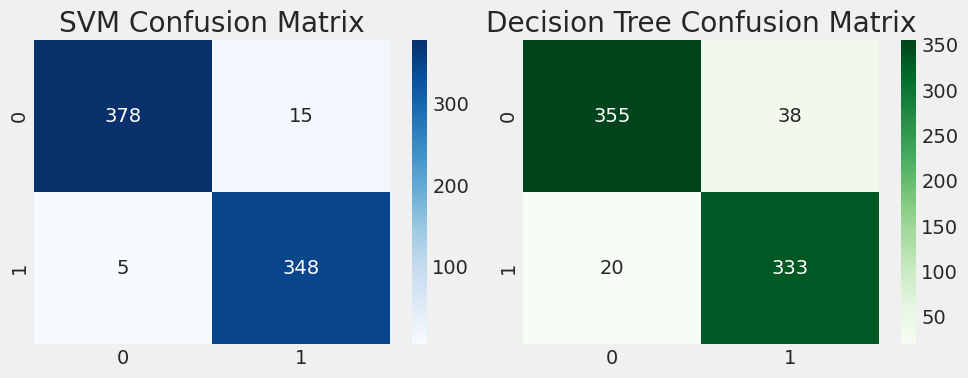

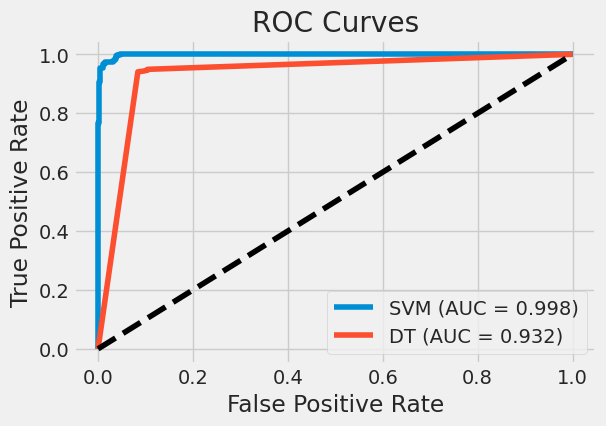


Error Analysis:
SVM errors: 20/746 (2.7%)
DT errors: 58/746 (7.8%)

GENERATING FINAL PREDICTIONS
Best model: SVM
Generated 869 predictions
Human (0): 569 (65.5%)
AI (1): 300 (34.5%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
print("\nTask 5: Model Evaluation")
print("="*25)

models = {'SVM': best_svm, 'Decision Tree': best_dt}

for name, model in models.items():
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {report['weighted avg']['f1-score']:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred))

svm_pred = best_svm.predict(X_val)
dt_pred = best_dt.predict(X_val)

svm_acc = accuracy_score(y_val, svm_pred)
dt_acc = accuracy_score(y_val, dt_pred)

print(f"\nModel Comparison:")
print(f"SVM Accuracy: {svm_acc:.4f}")
print(f"Decision Tree Accuracy: {dt_acc:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

cm_svm = confusion_matrix(y_val, svm_pred)
cm_dt = confusion_matrix(y_val, dt_pred)

import seaborn as sns
sns.heatmap(cm_svm, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('SVM Confusion Matrix')

sns.heatmap(cm_dt, annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title('Decision Tree Confusion Matrix')

plt.tight_layout()
plt.show()

svm_proba = best_svm.predict_proba(X_val)[:, 1]
dt_proba = best_dt.predict_proba(X_val)[:, 1]

fpr_svm, tpr_svm, _ = roc_curve(y_val, svm_proba)
fpr_dt, tpr_dt, _ = roc_curve(y_val, dt_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc(fpr_svm, tpr_svm):.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC = {auc(fpr_dt, tpr_dt):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

svm_errors = np.sum(y_val != svm_pred)
dt_errors = np.sum(y_val != dt_pred)

print(f"\nError Analysis:")
print(f"SVM errors: {svm_errors}/{len(y_val)} ({svm_errors/len(y_val)*100:.1f}%)")
print(f"DT errors: {dt_errors}/{len(y_val)} ({dt_errors/len(y_val)*100:.1f}%)")

print("\nGENERATING FINAL PREDICTIONS")
print("="*30)

if svm_acc > dt_acc:
    best_model = best_svm
    model_name = 'SVM'
else:
    best_model = best_dt
    model_name = 'Decision Tree'

print(f"Best model: {model_name}")

X_test_final = tfidf3.transform(test_text)
predictions = best_model.predict(X_test_final)

print(f"Generated {len(predictions)} predictions")
print(f"Human (0): {np.sum(predictions == 0)} ({np.sum(predictions == 0)/len(predictions)*100:.1f}%)")
print(f"AI (1): {np.sum(predictions == 1)} ({np.sum(predictions == 1)/len(predictions)*100:.1f}%)")

results = pd.DataFrame({
    'essay_id': range(len(df_test)),
    'predicted_label': predictions
})

results.to_csv('Natalia_DelRio_Assignment1_R11859713.csv', index=False)
files.download('Natalia_DelRio_Assignment1_R11859713.csv')